In [32]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import glob
import matchms
from matchms.plotting import plot_spectra_mirror

In [4]:
fname = 'checkpoints/small.80173081.validate_.00000600.output'

with open(fname,'rb') as f:
    p = pk.load(f)

In [6]:
p.keys()

dict_keys(['timing', 'running_loss', 'total_points', 'mean_loss', 'runtime', 'compute_time', 'run_efficiency', 'pts_per_sec', 'pred_spect', 'pred_formulae_probs', 'pred_input_idx', 'pred_input_mask', 'pred_true_spect', 'pred_formulae_features', 'pred_vert_element_oh'])

2023-03-30 14:30:20,100:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-03-30 14:30:20,101:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

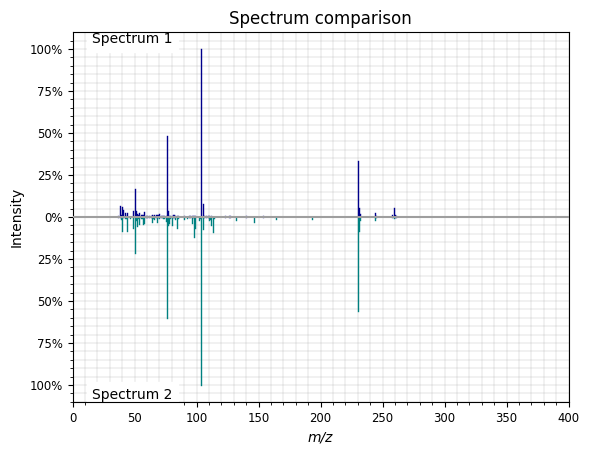

In [52]:
def to_matchms_spec(s):
    mzp = np.nonzero(s)[0]
    intp = s[mzp]
    return matchms.Spectrum(mz=mzp.astype(float), intensities = intp.astype(float))

idx = 42
spp = to_matchms_spec(p['pred_spect'][idx])
spt = to_matchms_spec(p['pred_true_spect'][idx])

plot_spectra_mirror(spp,spt)


In [54]:
matchms.set_matchms_logger_level("ERROR")

true = p['pred_true_spect']
pred = p['pred_spect']
n = len(true)

sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
dp = np.array([ float(s['score']) for s in dp ])

sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)
sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
sdp = np.array([ float(s['score']) for s in sdp ])


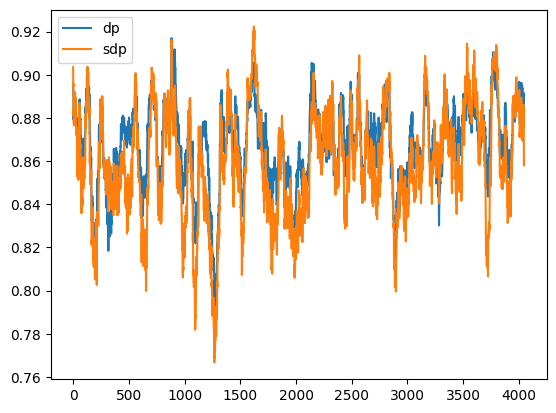

In [55]:
win = 50
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='dp')
plt.plot(smooth_sdp,label='sdp')
plt.legend()
#plt.plot([ float(s['matches']) for s in scores ])
plt.show()

In [56]:
np.mean(dp),np.std(dp)

(0.8676173198727783, 0.12075006851354393)

In [90]:
dps = []
sdps = []

for fn in sorted(glob.glob('checkpoints/*validate*.output')):
#for fn in sorted(glob.glob('checkpoints/*train*.output')):
    with open(fn,'rb') as pf:
        p = pk.load(pf)
    
    true = p['pred_true_spect']
    pred = p['pred_spect']
    n = len(true)

    dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
    dp = np.array([ float(s['score']) for s in dp ])
    dps.append((np.mean(dp),np.std(dp)))

    sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
    sdp = np.array([ float(s['score']) for s in sdp ])
    sdps.append((np.mean(sdp),np.std(sdp)))
    
dps = np.array(dps)
sdps = np.array(sdps)

    

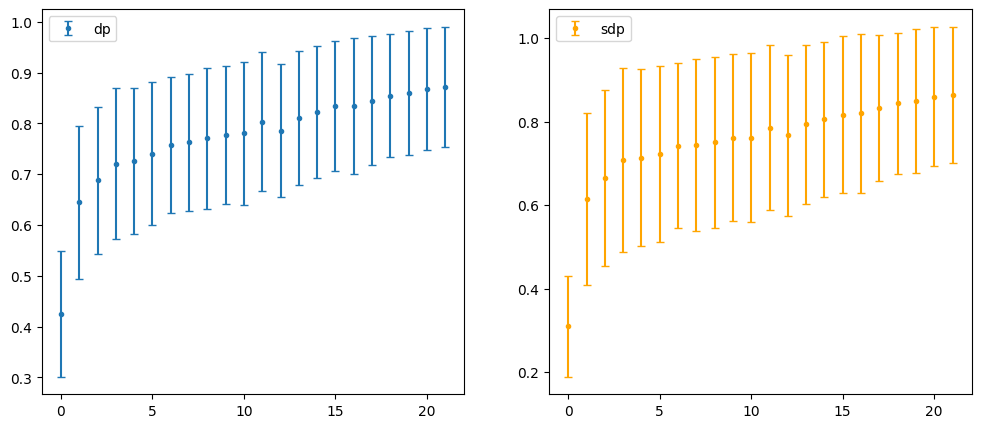

In [91]:
plt.figure(figsize=(12,5))
l = dps.shape[0]
plt.subplot(121)
plt.errorbar(x=range(l),y=dps[:,0],yerr=dps[:,1],label='dp',linestyle='None', marker='.',capsize=3)
plt.legend()
plt.subplot(122)
plt.errorbar(x=range(l),y=sdps[:,0],yerr=sdps[:,1],label='sdp',color='orange',linestyle='None', marker='.',capsize=3)
plt.legend()
plt.show()


In [93]:
dps[-1,:]

array([0.87212566, 0.1182891 ])